In [53]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor, Pool

In [54]:
df=pd.read_csv('data_for_exercise.csv', delimiter=';')
df.head(10)
#I took the market column as target variable and the spot column as the predicted values of market in the old strategy.

#Although wind data is too large and it seems unreasonable, I decided not to change the data and work with the data as it is.
#However, it still needs some data preprocessing. 

,Unnamed: 0,solar,wind,cons,market,spot
0,2019-01-01 01:00:00+01:00,00.00,226.482.641,41422.0,"11,98088293","10,07"
1,2019-01-01 02:00:00+01:00,00.00,247.626.254,40279.0,"5,776288908","-4,08"
2,2019-01-01 03:00:00+01:00,00.00,269.002.746,39035.0,"1,898098251","-9,91"
3,2019-01-01 04:00:00+01:00,00.00,292.117.893,38871.0,"0,605588431","-7,41"
4,2019-01-01 05:00:00+01:00,00.00,307.405.101,38508.0,"-1,794566262","-12,55"
5,2019-01-01 06:00:00+01:00,00.00,321.690.857,37630.0,"-3,365706863","-17,25"
6,2019-01-01 07:00:00+01:00,00.00,33.421.561,37987.0,"-2,171153355","-15,07"
7,2019-01-01 08:00:00+01:00,153.00.00,33.919.282,38653.0,"0,319497392","-4,93"
8,2019-01-01 09:00:00+01:00,1264.00.00,339.519.938,41315.0,"0,616599182","-6,33"
9,2019-01-01 10:00:00+01:00,2430.00.00,336.982.321,43822.0,"0,289136197","-4,93"


In [55]:
df.rename(columns={'Unnamed: 0':'ts'}, inplace=True)

In [56]:
df.shape

(2878, 6)

In [57]:
df['solar']=df['solar'].apply(lambda x: x.split('.')[0])
#df['wind']=df['wind'].apply(lambda x: x.split('.')[0])

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ts      2878 non-null   object 
 1   solar   2878 non-null   object 
 2   wind    2878 non-null   object 
 3   cons    2878 non-null   float64
 4   market  2878 non-null   object 
 5   spot    2878 non-null   object 
dtypes: float64(1), object(5)
memory usage: 135.0+ KB


In [59]:
#string data need to be converted to float
columns=['solar','wind','market','spot']
for i in columns:
    df[i]=df[i].apply(lambda x:(x.replace('.','')))
    df[i]=df[i].apply(lambda x:(x.replace(',','.')))
    df[i]=df[i].apply(lambda x: float(x))
df.head()

,ts,solar,wind,cons,market,spot
0,2019-01-01 01:00:00+01:00,0.0,226482641.0,41422.0,11.980883,10.07
1,2019-01-01 02:00:00+01:00,0.0,247626254.0,40279.0,5.776289,-4.08
2,2019-01-01 03:00:00+01:00,0.0,269002746.0,39035.0,1.898098,-9.91
3,2019-01-01 04:00:00+01:00,0.0,292117893.0,38871.0,0.605588,-7.41
4,2019-01-01 05:00:00+01:00,0.0,307405101.0,38508.0,-1.794566,-12.55


In [60]:
#extracting month, weekday and time
df['date']=df['ts'].apply(lambda x:x.split(' ')[0])
df['time']=df['ts'].apply(lambda x:int(x.split(' ')[1].split('+')[0].split(':')[0]))
df['weekday']=df['date'].apply(lambda x: pd.to_datetime (x).weekday())
df['month']=df['date'].apply(lambda x: pd.to_datetime(x).month)

df.head()

,ts,solar,wind,cons,market,spot,date,time,weekday,month
0,2019-01-01 01:00:00+01:00,0.0,226482641.0,41422.0,11.980883,10.07,2019-01-01,1,1,1
1,2019-01-01 02:00:00+01:00,0.0,247626254.0,40279.0,5.776289,-4.08,2019-01-01,2,1,1
2,2019-01-01 03:00:00+01:00,0.0,269002746.0,39035.0,1.898098,-9.91,2019-01-01,3,1,1
3,2019-01-01 04:00:00+01:00,0.0,292117893.0,38871.0,0.605588,-7.41,2019-01-01,4,1,1
4,2019-01-01 05:00:00+01:00,0.0,307405101.0,38508.0,-1.794566,-12.55,2019-01-01,5,1,1


In [61]:
df=df.drop(['ts','date'],axis=1)

In [62]:
#changing the order of columns#
df=df[['month','weekday','time','solar', 'wind', 'cons','market', 'spot']]
df

,month,weekday,time,solar,wind,cons,market,spot
0,1,1,1,0.0,226482641.0,41422.0,11.980883,10.07
1,1,1,2,0.0,247626254.0,40279.0,5.776289,-4.08
2,1,1,3,0.0,269002746.0,39035.0,1.898098,-9.91
3,1,1,4,0.0,292117893.0,38871.0,0.605588,-7.41
4,1,1,5,0.0,307405101.0,38508.0,-1.794566,-12.55
...,...,...,...,...,...,...,...,...
2873,4,1,19,1801.0,7447472.0,61012.0,50.239146,54.40
2874,4,1,20,304.0,75531701.0,59910.0,49.589835,51.76
2875,4,1,21,0.0,71203044.0,58277.0,47.151411,48.71
2876,4,1,22,0.0,70001985.0,54546.0,43.846923,46.28


In [63]:
#treating missing value
df.isnull().any()
#there is no missing value

month      False
weekday    False
time       False
solar      False
wind       False
cons       False
market     False
spot       False
dtype: bool

<AxesSubplot:xlabel='market', ylabel='Count'>

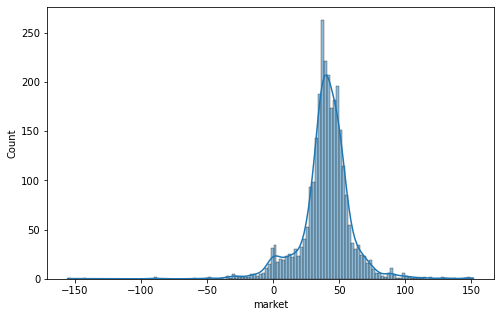

In [64]:
#treating outliers
#histogram
plt.figure(figsize=(8,5))
sns.histplot(df['market'],kde=True)

C:\Users\Marzieh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='market'>

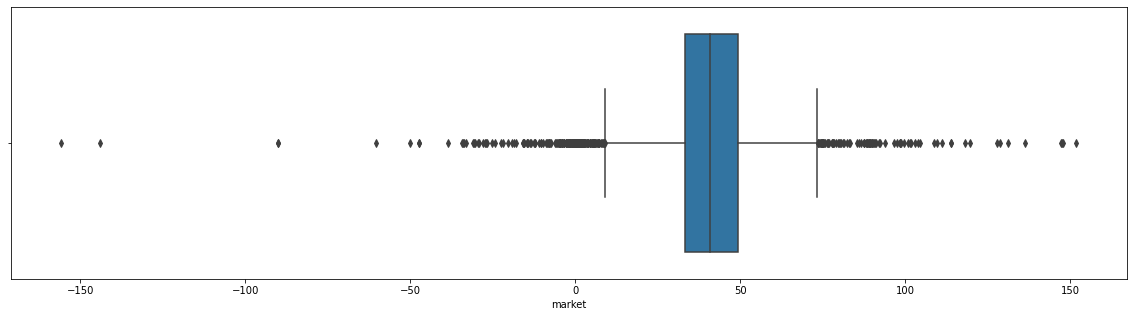

In [65]:
#boxplot
plt.figure(figsize=(20,5))
sns.boxplot(df['market'])

In [66]:
df=df.drop(df.loc[df['market']<-50].index, axis=0)
# now market data has a near normal distribution

<AxesSubplot:>

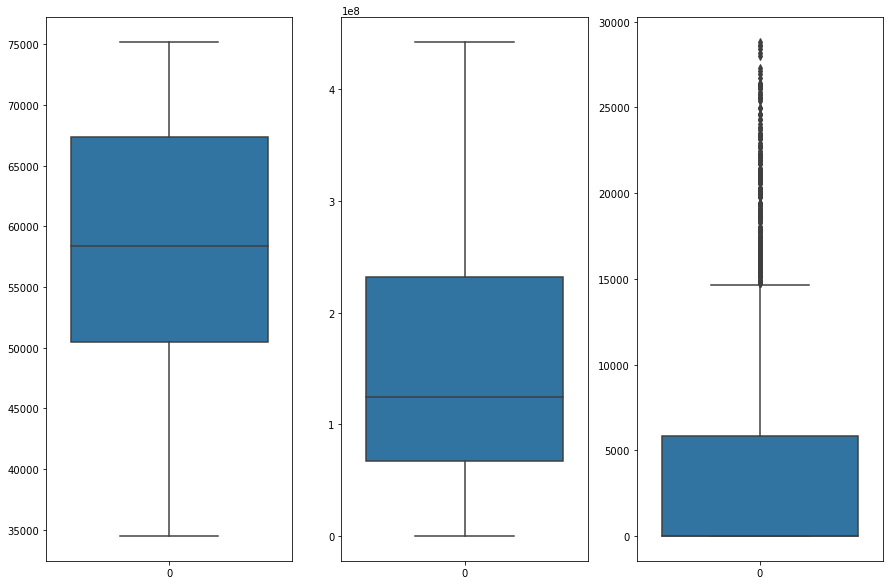

In [67]:
figure, axes = plt.subplots(1,3)
figure.set_size_inches(15, 10)
plt.subplot(1,3,1)
sns.boxplot(data=df['cons'])
plt.subplot(1,3,2)
sns.boxplot(data=df['wind'])
plt.subplot(1,3,3)
sns.boxplot(data=df['solar'])
# there is no outlier

<AxesSubplot:xlabel='month', ylabel='market'>

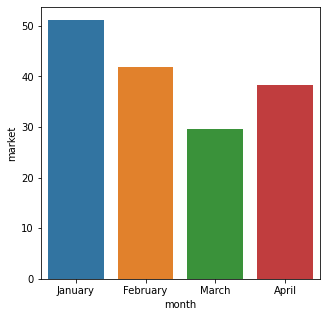

In [68]:
#bar plot (average of market price by month)
month = ["January","February","March","April"]
month_df=pd.DataFrame(df.groupby('month')['market'].mean()).reset_index().sort_values(by='month')
month_df['month']=month
plt.figure(figsize=(5,5))
sns.barplot(data=month_df,x='month',y='market')

<AxesSubplot:xlabel='time', ylabel='market'>

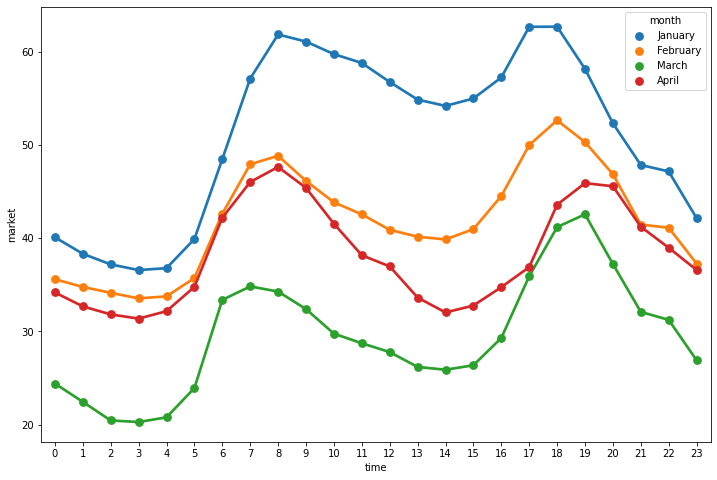

In [69]:
#point plot (average of market price by hour and month)
hour_market=pd.DataFrame(df.groupby(['time','month'])['market'].mean()).reset_index()
hour_market['month'].replace([1,2,3,4],["January","February","March","April"],inplace=True)
plt.figure(figsize=(12,8))
sns.pointplot(x=hour_market["time"], y=hour_market["market"],hue=hour_market["month"], data=hour_market)

<AxesSubplot:xlabel='time', ylabel='cons'>

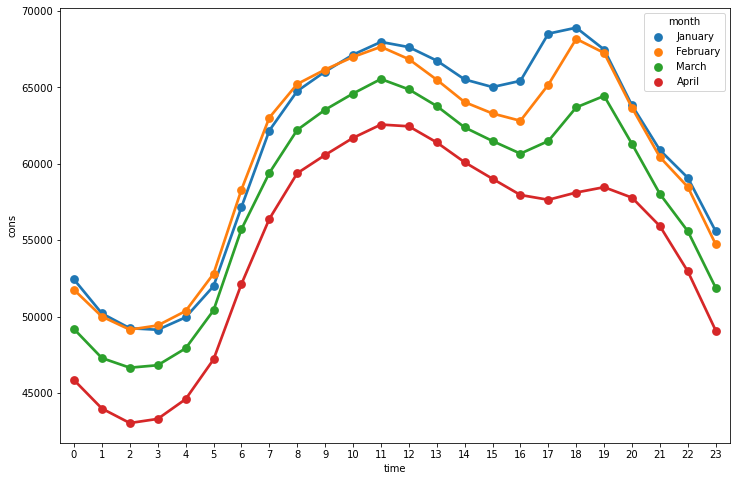

In [70]:
#point plot (average of cons by hour and month)
hour_cons=pd.DataFrame(df.groupby(['time','month'])['cons'].mean()).reset_index()
hour_cons['month'].replace([1,2,3,4],["January","February","March","April"],inplace=True)
plt.figure(figsize=(12,8))
sns.pointplot(x=hour_cons["time"], y=hour_cons["cons"],hue=hour_cons["month"], data=hour_cons)

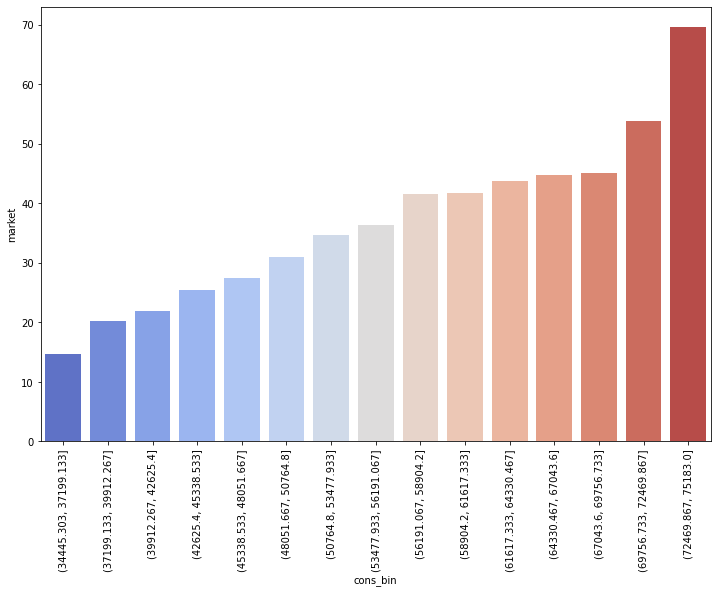

In [71]:
#bar plot (average of market price by cons_bin)
plt.figure(figsize=(12,8))
cons_df=df.copy()
cons_df['cons_bin']=pd.cut(cons_df['cons'],15)
cons_df=pd.DataFrame(cons_df.groupby('cons_bin')['market'].mean()).reset_index()
ax=sns.barplot(data=cons_df,x='cons_bin', y='market', palette='coolwarm')
ax.set_xticklabels( ax.get_xticklabels(),rotation=90);

In [72]:
old_strategy=df['spot']

In [73]:
df=df.drop('spot',axis=1)

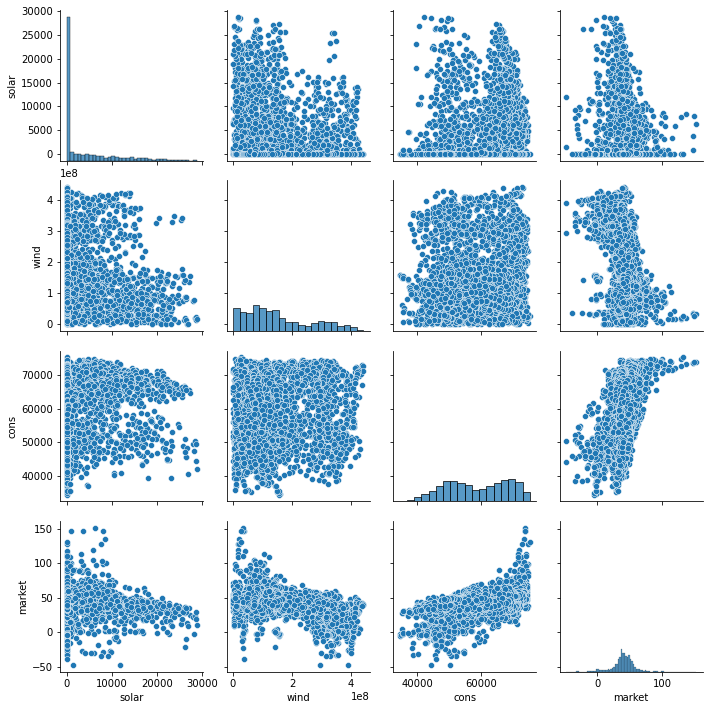

In [74]:
sns.pairplot(df[['solar','wind','cons','market']])

In [75]:
# it is evident that the relationship between market data and input variables (wind and solar forcast) is not linear.
# So, we should choose models that are suitable for capturing nonlinearity among data.
# we apply catboost algorithm which is strong algotithm with tree base structure and good for nonlinear data
# and  handling categorical data that we have in our model, such as month, weekday, time.

In [76]:
columns=['month','weekday']
for i in columns:
    df[i]=df[i].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2872 entries, 0 to 2877
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   month    2872 non-null   object 
 1   weekday  2872 non-null   object 
 2   time     2872 non-null   int64  
 3   solar    2872 non-null   float64
 4   wind     2872 non-null   float64
 5   cons     2872 non-null   float64
 6   market   2872 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 244.0+ KB


In [77]:
y=df['market']
X=df.drop('market', axis=1)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

In [79]:
#Scaling the data after outliers removal
'''
scaler=MinMaxScaler()
scaled_Xtrain=scaler.fit_transform(X_train[['solar','wind','cons']])
scaled_Xtest=scaler.transform(X_test[['solar','wind','cons']])
scaled_Xtrain=np.concatenate([X_train[['month','weekday','time']],scaled_Xtrain],axis=1)
scaled_Xtest=np.concatenate([X_test[['month','weekday','time']],scaled_Xtest],axis=1)
scaled_Xtest
'''

"\nscaler=MinMaxScaler()\nscaled_Xtrain=scaler.fit_transform(X_train[['solar','wind','cons']])\nscaled_Xtest=scaler.transform(X_test[['solar','wind','cons']])\nscaled_Xtrain=np.concatenate([X_train[['month','weekday','time']],scaled_Xtrain],axis=1)\nscaled_Xtest=np.concatenate([X_test[['month','weekday','time']],scaled_Xtest],axis=1)\nscaled_Xtest\n"

In [80]:
'''
model=CatBoostRegressor(one_hot_max_size=7,verbose=0, loss_function='RMSE')
n_estimators = [300,500,700]
max_depth = [5,10]
learning_rate = [0.03,0.05,0.1]
param={'n_estimators':n_estimators,'max_depth':max_depth, 'learning_rate':learning_rate}
CB=GridSearchCV(estimator=model,param_grid=param,cv=5,scoring='neg_mean_squared_error')
CB.fit(X_train,y_train)
best_param=CB.best_params_
best_param
'''
# based on grid search result, best params are {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 700}
#for decreasing the computation time, these codes were run one time and then we use the results in the next cell

"\nmodel=CatBoostRegressor(one_hot_max_size=7,verbose=0, loss_function='RMSE')\nn_estimators = [300,500,700]\nmax_depth = [5,10]\nlearning_rate = [0.03,0.05,0.1]\nparam={'n_estimators':n_estimators,'max_depth':max_depth, 'learning_rate':learning_rate}\nCB=GridSearchCV(estimator=model,param_grid=param,cv=5,scoring='neg_mean_squared_error')\nCB.fit(X_train,y_train)\nbest_param=CB.best_params_\nbest_param\n"

In [81]:
#new strategy
pool_train = Pool(X_train, y_train,cat_features = [0,1])
pool_test = Pool(X_test, cat_features =[0,1])
CB=CatBoostRegressor(n_estimators=700, max_depth=10,learning_rate=0.05, one_hot_max_size=7,verbose=0,loss_function='RMSE')

CB.fit(pool_train)
predicted=CB.predict(pool_test) 
Score1_new=mean_squared_error(y_test,predicted)
Score2_new=r2_score(y_test,predicted)
print('my strategy score: MSE={:.2f} , r2_score={:.2f}' .format(Score1_new,Score2_new))

my strategy score: MSE=40.71 , r2_score=0.91


In [82]:
#old strategy
y_test_sorted=y_test.sort_index()
old_strategy_test=old_strategy[old_strategy.index.isin(y_test.index)]
Score1_old=mean_squared_error(y_test_sorted,old_strategy_test)
Score2_old=r2_score(y_test_sorted,old_strategy_test)
print('old strategy score: MSE={:.2f} , r2_score={:.2f}' .format(Score1_old,Score2_old))

old strategy score: MSE=56.95 , r2_score=0.87


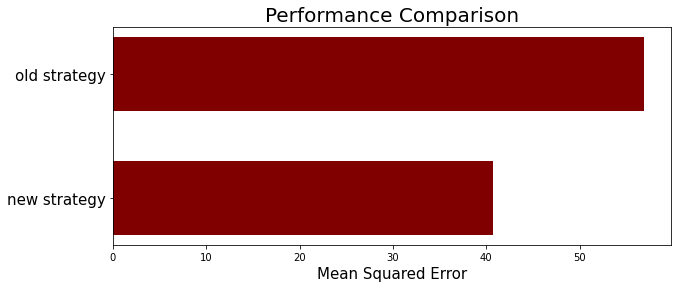

In [83]:
fig = plt.figure(figsize=(10, 4))
plt.barh(['new strategy','old strategy'],[Score1_new,Score1_old],color='maroon',height=0.6 )
plt.xlabel("Mean Squared Error", fontsize=15)
plt.title("Performance Comparison", fontsize=20)
plt.yticks(fontsize=15)
plt.show()